In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
df_data = pd.read_csv('./Data/data_processed.csv').dropna()
le = preprocessing.LabelEncoder()
df_data['class'] = le.fit_transform(df_data.genre)
df_data

,title,genre,summary,clean_text,clean_title,class
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,drown wednesday first trustee among morrow day...,drown wednesday,1
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",book open jason awakens school bus unable reme...,lose hero,1
2,Thendara House,fantasy,The novel concerns the dwelling of the Darkov...,novel concern dwell darkovan order renunciates...,thendara house,1
3,The Thief,fantasy,"Gen is released from prison by the magus, the...",gen release prison magus king scholar magus fi...,thief,1
4,The Sweet Far Thing,fantasy,The prologue begins with two men who are sear...,prologue begin two men search river london thr...,sweet far thing,1
...,...,...,...,...,...,...
2995,The Time Traveler's Wife,fantasy,This is the extraordinary love story of Clare ...,extraordinary love story clare henry meet clar...,time traveler wife,1
2996,Fantastic Beasts and Where to Find Them: The O...,fantasy,J.K. Rowling's screenwriting debut is captured...,j k rowling screenwriting debut capture exciti...,fantastic beast find original screenplay,1
2997,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,charlie bucket wonderful adventure begin find ...,charlie chocolate factory,1
2998,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...",rise love dimitri dimitri might love tasha mas...,frostbite,1


In [3]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, text, Y, transform = None):
        self.text = text
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.text[idx], self.Y[idx]
    

def str2idx(df, word2index, cut_length):
    idx_seq_li = []
    for i in range(len(df)):
        idx_li = []
        for w in word_tokenize(df.clean_text.iloc[i]):
            if word2index.get(w):
                idx = word2index[w]
            else:
                idx = word2index['UNK']
            idx_li.append(idx)

        if len(idx_li) >= cut_length:
            idx_li = idx_li[:cut_length]
        else:
            for i in range(cut_length - len(idx_li)):
                idx_li.append(0)
        idx_seq_li.append(idx_li)
    return np.array(idx_seq_li)


def generate_data_loader(df_data, batch_size, cut_length):
    
    X = np.arange(len(df_data))
    y = df_data['class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=23)

    data_train = df_data.iloc[X_train]
    data_test = df_data.iloc[X_test] 

    # word2index
    all_words = [i for w in list(data_train.clean_text) for i in word_tokenize(w)]
    unique_words = list(set(all_words))
    word2index = {w:i+1 for i,w in enumerate(unique_words)}
    word2index['PAD'] = 0
    word2index['UNK'] = len(word2index)

    train_arr = str2idx(data_train, word2index, cut_length)
    test_arr = str2idx(data_test, word2index, cut_length)

    train_data = TextDataset(torch.from_numpy(train_arr).long(), 
                         torch.from_numpy(y_train.to_numpy()).long())

    test_data = TextDataset(torch.from_numpy(test_arr).long(),
                        torch.from_numpy(y_test.to_numpy()).long())

    train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
    
    return data_train, data_test, train_loader, test_loader, word2index

In [4]:
class TextCNN(nn.ModuleList):

    def __init__(self, params):
        super(TextCNN, self).__init__()

        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = params.embedding_size

        # Dropout definition
        self.dropout = nn.Dropout(0.5)

        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5

        # Output size for each convolution
        self.out_size = params.out_size
        
        # Number of strides for each convolution
        self.stride = params.stride
        
        # Dense layers
        self.dense_out = params.dense_out
        self.class_num = params.class_num

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words, self.embedding_size, padding_idx=0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)

        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)

        # Fully connected layer definition
        self.fc1 = nn.Linear(self.in_features_fc(), self.dense_out)
        self.fc2 = nn.Linear(self.dense_out, self.class_num)
        
        
    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
    
    
    def forward(self, x):

        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)

        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)

        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)

        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        union = union.reshape(union.size(0), -1)

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc1(union)
        # Dropout is applied
        out = self.dropout(out)
        out = self.fc2(out)
        # Activation function is applied
        out = F.log_softmax(out, dim=1)

        return out

In [5]:
batch_size = 128
cut_length = 500
data_train, data_test, train_loader, test_loader, word2index = generate_data_loader(df_data, batch_size, cut_length)


@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = cut_length
    num_words: int = len(word2index)

    # Model parameters
    embedding_size: int = 100
    out_size: int = 64
    stride: int = 2
    class_num: int = len(le.classes_)
    dense_out: int =128
        
param = Parameters
lr = 0.001
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TextCNN(param).to(device)
print(model)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-8)

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # train
    train_epoch_loss = 0
    # set net to train mode
    model.train()
    train_preds = []
    
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        # pass the data into the network and store the output 
        y_train_pred = model(X_train)
        # Calculate the loss between the output and target 
        train_loss = criterion(y_train_pred, y_train)

        # Perform backpropagation 
        l2_lambda = 0.01
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        train_loss += l2_lambda * l2_reg
        
        train_loss.backward()
        optimizer.step()

        # Add the loss 
        train_epoch_loss +=  train_loss.item() 
        
        # Prediction
        train_preds += list(torch.argmax(y_train_pred, dim=1).cpu().detach().numpy())
        
    # validation 
    with torch.no_grad():
        val_preds = []
        val_epoch_loss = 0
        model.eval()
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)

            val_loss = criterion(y_val_pred, y_val)
            l2_lambda = 0.01
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            val_loss += l2_lambda * l2_reg
            val_epoch_loss +=  val_loss.item() 
            val_preds += list(torch.argmax(y_val_pred, dim=1).cpu().detach().numpy())
            
    # append average epoch loss to losses list  
    train_losses.append(train_epoch_loss/len(train_loader))
    val_losses.append(val_epoch_loss/len(test_loader)) 
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'\
      .format(epoch + 1, num_epochs,train_losses[-1],val_losses[-1]))
    print('train accuracy {} \t val accuracy {}'\
      .format(accuracy_score(data_train['class'], train_preds), 
              accuracy_score(data_test['class'], val_preds)))


TextCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(37949, 100, padding_idx=0)
  (conv_1): Conv1d(500, 64, kernel_size=(2,), stride=(2,))
  (conv_2): Conv1d(500, 64, kernel_size=(3,), stride=(2,))
  (conv_3): Conv1d(500, 64, kernel_size=(4,), stride=(2,))
  (conv_4): Conv1d(500, 64, kernel_size=(5,), stride=(2,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

 EPOCH 1/1000 	 train loss 22.02266649766402 	 val loss 21.517422358194988
train accuracy 0.1716833890746934 	 val accuracy 0.16666666666666666

 EPOCH 2/1000 	 train loss 21.07957571203


 EPOCH 54/1000 	 train loss 9.736793344671076 	 val loss 12.388250033060709
train accuracy 0.9914529914529915 	 val accuracy 0.34

 EPOCH 55/1000 	 train loss 9.612475872039795 	 val loss 12.307688077290853
train accuracy 0.9914529914529915 	 val accuracy 0.3333333333333333

 EPOCH 56/1000 	 train loss 9.49328344518488 	 val loss 12.166936238606771
train accuracy 0.9903381642512077 	 val accuracy 0.3466666666666667

 EPOCH 57/1000 	 train loss 9.378996675664728 	 val loss 11.90692933400472
train accuracy 0.9918246005202527 	 val accuracy 0.35

 EPOCH 58/1000 	 train loss 9.2491793199019 	 val loss 11.702515920003256
train accuracy 0.990709773318469 	 val accuracy 0.33666666666666667

 EPOCH 59/1000 	 train loss 9.14688236063177 	 val loss 11.779008865356445
train accuracy 0.9903381642512077 	 val accuracy 0.33666666666666667

 EPOCH 60/1000 	 train loss 9.01054859161377 	 val loss 11.423188209533691
train accuracy 0.992196209587514 	 val accuracy 0.3433333333333333

 EPOCH 61/1000 	 t


 EPOCH 113/1000 	 train loss 3.910772366957231 	 val loss 5.769666353861491
train accuracy 0.989223337049424 	 val accuracy 0.3566666666666667

 EPOCH 114/1000 	 train loss 3.8411989970640703 	 val loss 5.799931049346924
train accuracy 0.9899665551839465 	 val accuracy 0.35333333333333333

 EPOCH 115/1000 	 train loss 3.767769553444602 	 val loss 5.641360600789388
train accuracy 0.9903381642512077 	 val accuracy 0.35333333333333333

 EPOCH 116/1000 	 train loss 3.696220647205006 	 val loss 5.615513960520427
train accuracy 0.9903381642512077 	 val accuracy 0.3566666666666667

 EPOCH 117/1000 	 train loss 3.6302226456728848 	 val loss 5.453258673350017
train accuracy 0.9895949461166852 	 val accuracy 0.36333333333333334

 EPOCH 118/1000 	 train loss 3.560241395776922 	 val loss 5.470612684885661
train accuracy 0.9899665551839465 	 val accuracy 0.3566666666666667

 EPOCH 119/1000 	 train loss 3.4953958988189697 	 val loss 5.332213401794434
train accuracy 0.9914529914529915 	 val accuracy


 EPOCH 172/1000 	 train loss 1.2704027674414895 	 val loss 3.166499058405558
train accuracy 0.9903381642512077 	 val accuracy 0.49

 EPOCH 173/1000 	 train loss 1.2549783153967424 	 val loss 3.2761847178141275
train accuracy 0.9899665551839465 	 val accuracy 0.48

 EPOCH 174/1000 	 train loss 1.23501455783844 	 val loss 3.5001691977183023
train accuracy 0.989223337049424 	 val accuracy 0.43666666666666665

 EPOCH 175/1000 	 train loss 1.219902434132316 	 val loss 3.3648910522460938
train accuracy 0.9899665551839465 	 val accuracy 0.45666666666666667

 EPOCH 176/1000 	 train loss 1.2065555724230679 	 val loss 3.447081963221232
train accuracy 0.9888517279821628 	 val accuracy 0.44666666666666666

 EPOCH 177/1000 	 train loss 1.1958286924795671 	 val loss 3.9954419136047363
train accuracy 0.9858788554440728 	 val accuracy 0.43666666666666665

 EPOCH 178/1000 	 train loss 1.1986732320352034 	 val loss 2.970194657643636
train accuracy 0.986250464511334 	 val accuracy 0.5233333333333333

 E


 EPOCH 230/1000 	 train loss 0.7176580889658495 	 val loss 2.2366217772165933
train accuracy 0.9903381642512077 	 val accuracy 0.5633333333333334

 EPOCH 231/1000 	 train loss 0.7090092978694222 	 val loss 2.22458553314209
train accuracy 0.9925678186547752 	 val accuracy 0.58

 EPOCH 232/1000 	 train loss 0.7027808861298994 	 val loss 2.2210306326548257
train accuracy 0.989223337049424 	 val accuracy 0.58

 EPOCH 233/1000 	 train loss 0.6962995312430642 	 val loss 2.24496062596639
train accuracy 0.990709773318469 	 val accuracy 0.5466666666666666

 EPOCH 234/1000 	 train loss 0.688506695357236 	 val loss 2.207038402557373
train accuracy 0.9903381642512077 	 val accuracy 0.5833333333333334

 EPOCH 235/1000 	 train loss 0.6821436556902799 	 val loss 2.2011681397755942
train accuracy 0.9895949461166852 	 val accuracy 0.57

 EPOCH 236/1000 	 train loss 0.6749128888953816 	 val loss 2.203465382258097
train accuracy 0.9895949461166852 	 val accuracy 0.57

 EPOCH 237/1000 	 train loss 0.6698


 EPOCH 289/1000 	 train loss 0.4459056258201599 	 val loss 1.836970289548238
train accuracy 0.9899665551839465 	 val accuracy 0.6166666666666667

 EPOCH 290/1000 	 train loss 0.44048582830212335 	 val loss 1.8175349235534668
train accuracy 0.9914529914529915 	 val accuracy 0.61

 EPOCH 291/1000 	 train loss 0.43633364140987396 	 val loss 1.817724347114563
train accuracy 0.9903381642512077 	 val accuracy 0.6133333333333333

 EPOCH 292/1000 	 train loss 0.43104993348771875 	 val loss 1.807965636253357
train accuracy 0.9914529914529915 	 val accuracy 0.61

 EPOCH 293/1000 	 train loss 0.4278410944071683 	 val loss 1.8030998706817627
train accuracy 0.989223337049424 	 val accuracy 0.62

 EPOCH 294/1000 	 train loss 0.423649017106403 	 val loss 1.7981245120366414
train accuracy 0.9910813823857302 	 val accuracy 0.6066666666666667

 EPOCH 295/1000 	 train loss 0.42027064209634607 	 val loss 1.7987950642903645
train accuracy 0.990709773318469 	 val accuracy 0.6166666666666667

 EPOCH 296/100


 EPOCH 347/1000 	 train loss 0.323687420649962 	 val loss 1.51657501856486
train accuracy 0.9910813823857302 	 val accuracy 0.6533333333333333

 EPOCH 348/1000 	 train loss 0.32126308435743506 	 val loss 1.5136911074320476
train accuracy 0.9918246005202527 	 val accuracy 0.6333333333333333

 EPOCH 349/1000 	 train loss 0.3186204054138877 	 val loss 1.5287565390268962
train accuracy 0.9910813823857302 	 val accuracy 0.65

 EPOCH 350/1000 	 train loss 0.31561243534088135 	 val loss 1.509412129720052
train accuracy 0.990709773318469 	 val accuracy 0.6433333333333333

 EPOCH 351/1000 	 train loss 0.31166516650806775 	 val loss 1.5004292726516724
train accuracy 0.9899665551839465 	 val accuracy 0.6466666666666666

 EPOCH 352/1000 	 train loss 0.3099171912128275 	 val loss 1.4984498421351116
train accuracy 0.9903381642512077 	 val accuracy 0.6533333333333333

 EPOCH 353/1000 	 train loss 0.3076416822997006 	 val loss 1.5105654795964558
train accuracy 0.9899665551839465 	 val accuracy 0.6433


 EPOCH 405/1000 	 train loss 0.26979369060559705 	 val loss 1.3456316391626995
train accuracy 0.9903381642512077 	 val accuracy 0.6633333333333333

 EPOCH 406/1000 	 train loss 0.2679757157509977 	 val loss 1.3306807279586792
train accuracy 0.990709773318469 	 val accuracy 0.6533333333333333

 EPOCH 407/1000 	 train loss 0.2672721337188374 	 val loss 1.3404709100723267
train accuracy 0.9903381642512077 	 val accuracy 0.6633333333333333

 EPOCH 408/1000 	 train loss 0.26529285447164014 	 val loss 1.3419368267059326
train accuracy 0.9910813823857302 	 val accuracy 0.6633333333333333

 EPOCH 409/1000 	 train loss 0.26744811914183875 	 val loss 1.343956748644511
train accuracy 0.9903381642512077 	 val accuracy 0.6566666666666666

 EPOCH 410/1000 	 train loss 0.2653795426542109 	 val loss 1.3153255383173625
train accuracy 0.990709773318469 	 val accuracy 0.6633333333333333

 EPOCH 411/1000 	 train loss 0.26218534125523135 	 val loss 1.337200125058492
train accuracy 0.992196209587514 	 val 


 EPOCH 463/1000 	 train loss 0.2583072009411725 	 val loss 1.3239450454711914
train accuracy 0.9895949461166852 	 val accuracy 0.6566666666666666

 EPOCH 464/1000 	 train loss 0.2613274875012311 	 val loss 1.4768054087956746
train accuracy 0.992196209587514 	 val accuracy 0.65

 EPOCH 465/1000 	 train loss 0.26594540815461765 	 val loss 1.5721696217854817
train accuracy 0.990709773318469 	 val accuracy 0.6466666666666666

 EPOCH 466/1000 	 train loss 0.2772774879227985 	 val loss 1.330390493075053
train accuracy 0.989223337049424 	 val accuracy 0.6733333333333333

 EPOCH 467/1000 	 train loss 0.28156044672835956 	 val loss 1.5480132102966309
train accuracy 0.9899665551839465 	 val accuracy 0.6133333333333333

 EPOCH 468/1000 	 train loss 0.2987314056266438 	 val loss 1.659702221552531
train accuracy 0.987736900780379 	 val accuracy 0.6

 EPOCH 469/1000 	 train loss 0.31966648589481006 	 val loss 1.5812372763951619
train accuracy 0.9843924191750278 	 val accuracy 0.6533333333333333

 E


 EPOCH 521/1000 	 train loss 0.24860690534114838 	 val loss 1.3042045434315999
train accuracy 0.9910813823857302 	 val accuracy 0.6566666666666666

 EPOCH 522/1000 	 train loss 0.24877948381684042 	 val loss 1.292632023493449
train accuracy 0.9929394277220365 	 val accuracy 0.68

 EPOCH 523/1000 	 train loss 0.24952902577140115 	 val loss 1.3103781938552856
train accuracy 0.9914529914529915 	 val accuracy 0.6833333333333333

 EPOCH 524/1000 	 train loss 0.2528162652795965 	 val loss 1.2583305835723877
train accuracy 0.9903381642512077 	 val accuracy 0.6833333333333333

 EPOCH 525/1000 	 train loss 0.2493835281242024 	 val loss 1.2461934487024944
train accuracy 0.9910813823857302 	 val accuracy 0.6733333333333333

 EPOCH 526/1000 	 train loss 0.24818433279340918 	 val loss 1.306086778640747
train accuracy 0.9918246005202527 	 val accuracy 0.69

 EPOCH 527/1000 	 train loss 0.2497903128916567 	 val loss 1.3237212498982747
train accuracy 0.992196209587514 	 val accuracy 0.683333333333333


 EPOCH 579/1000 	 train loss 0.2425778711383993 	 val loss 1.2340001265207927
train accuracy 0.9918246005202527 	 val accuracy 0.6966666666666667

 EPOCH 580/1000 	 train loss 0.24294501068917188 	 val loss 1.2309685548146565
train accuracy 0.9929394277220365 	 val accuracy 0.67

 EPOCH 581/1000 	 train loss 0.24469735744324597 	 val loss 1.2127691109975178
train accuracy 0.9929394277220365 	 val accuracy 0.6933333333333334

 EPOCH 582/1000 	 train loss 0.25157131999731064 	 val loss 1.2640276352564495
train accuracy 0.9925678186547752 	 val accuracy 0.7

 EPOCH 583/1000 	 train loss 0.2511671361598102 	 val loss 1.2159096797307332
train accuracy 0.9918246005202527 	 val accuracy 0.6966666666666667

 EPOCH 584/1000 	 train loss 0.248430150476369 	 val loss 1.2240355809529622
train accuracy 0.990709773318469 	 val accuracy 0.67

 EPOCH 585/1000 	 train loss 0.24809809638695282 	 val loss 1.2301371494928997
train accuracy 0.9918246005202527 	 val accuracy 0.6866666666666666

 EPOCH 586/


 EPOCH 637/1000 	 train loss 0.35421382026238873 	 val loss 1.6580415566762288
train accuracy 0.9884801189149015 	 val accuracy 0.6366666666666667

 EPOCH 638/1000 	 train loss 0.32554465396837756 	 val loss 1.5208570559819539
train accuracy 0.9914529914529915 	 val accuracy 0.6366666666666667

 EPOCH 639/1000 	 train loss 0.29673626206137915 	 val loss 1.4133371512095134
train accuracy 0.9918246005202527 	 val accuracy 0.64

 EPOCH 640/1000 	 train loss 0.2780229869213971 	 val loss 1.367614507675171
train accuracy 0.9918246005202527 	 val accuracy 0.6566666666666666

 EPOCH 641/1000 	 train loss 0.26888227462768555 	 val loss 1.3405822118123372
train accuracy 0.9910813823857302 	 val accuracy 0.6533333333333333

 EPOCH 642/1000 	 train loss 0.2617229013280435 	 val loss 1.3206350008646648
train accuracy 0.9925678186547752 	 val accuracy 0.6633333333333333

 EPOCH 643/1000 	 train loss 0.25961416959762573 	 val loss 1.3094919522603352
train accuracy 0.990709773318469 	 val accuracy 0


 EPOCH 695/1000 	 train loss 0.24805201319130984 	 val loss 1.218591332435608
train accuracy 0.9914529914529915 	 val accuracy 0.67

 EPOCH 696/1000 	 train loss 0.24605888399210843 	 val loss 1.2074844042460124
train accuracy 0.9903381642512077 	 val accuracy 0.67

 EPOCH 697/1000 	 train loss 0.24364137243140827 	 val loss 1.2016619046529133
train accuracy 0.9903381642512077 	 val accuracy 0.6766666666666666

 EPOCH 698/1000 	 train loss 0.24248602038080042 	 val loss 1.2107671896616619
train accuracy 0.9929394277220365 	 val accuracy 0.6766666666666666

 EPOCH 699/1000 	 train loss 0.24075401709838348 	 val loss 1.2061009804407756
train accuracy 0.9918246005202527 	 val accuracy 0.68

 EPOCH 700/1000 	 train loss 0.24023679508404297 	 val loss 1.2159806092580159
train accuracy 0.992196209587514 	 val accuracy 0.68

 EPOCH 701/1000 	 train loss 0.24136655032634735 	 val loss 1.2109180688858032
train accuracy 0.992196209587514 	 val accuracy 0.6766666666666666

 EPOCH 702/1000 	 trai


 EPOCH 753/1000 	 train loss 0.24004935811866412 	 val loss 1.2402537663777669
train accuracy 0.9925678186547752 	 val accuracy 0.6933333333333334

 EPOCH 754/1000 	 train loss 0.24191199175336145 	 val loss 1.2658752997716267
train accuracy 0.9910813823857302 	 val accuracy 0.6933333333333334

 EPOCH 755/1000 	 train loss 0.2431939643892375 	 val loss 1.2594852844874065
train accuracy 0.9918246005202527 	 val accuracy 0.6933333333333334

 EPOCH 756/1000 	 train loss 0.24259841577573257 	 val loss 1.2831109364827473
train accuracy 0.9925678186547752 	 val accuracy 0.6633333333333333

 EPOCH 757/1000 	 train loss 0.24481857026165182 	 val loss 1.2840234835942586
train accuracy 0.9929394277220365 	 val accuracy 0.6833333333333333

 EPOCH 758/1000 	 train loss 0.24848360500552438 	 val loss 1.3073265155156453
train accuracy 0.9895949461166852 	 val accuracy 0.6833333333333333

 EPOCH 759/1000 	 train loss 0.247514584525065 	 val loss 1.243629773457845
train accuracy 0.9933110367892977 	 


 EPOCH 811/1000 	 train loss 0.23926783759485593 	 val loss 1.2167528470357258
train accuracy 0.9925678186547752 	 val accuracy 0.6666666666666666

 EPOCH 812/1000 	 train loss 0.23933785408735275 	 val loss 1.2031862338383992
train accuracy 0.9910813823857302 	 val accuracy 0.6866666666666666

 EPOCH 813/1000 	 train loss 0.23871597038073974 	 val loss 1.199106256167094
train accuracy 0.992196209587514 	 val accuracy 0.6866666666666666

 EPOCH 814/1000 	 train loss 0.2382402243939313 	 val loss 1.2196507453918457
train accuracy 0.9910813823857302 	 val accuracy 0.6866666666666666

 EPOCH 815/1000 	 train loss 0.2372135127132589 	 val loss 1.2160715262095134
train accuracy 0.9918246005202527 	 val accuracy 0.69

 EPOCH 816/1000 	 train loss 0.23613318529996005 	 val loss 1.1997074286142986
train accuracy 0.9918246005202527 	 val accuracy 0.6933333333333334

 EPOCH 817/1000 	 train loss 0.2371784888885238 	 val loss 1.2158395846684773
train accuracy 0.992196209587514 	 val accuracy 0.6


 EPOCH 869/1000 	 train loss 0.24045130949128757 	 val loss 1.2254526615142822
train accuracy 0.990709773318469 	 val accuracy 0.6833333333333333

 EPOCH 870/1000 	 train loss 0.24057789553295483 	 val loss 1.2006609837214153
train accuracy 0.9918246005202527 	 val accuracy 0.6733333333333333

 EPOCH 871/1000 	 train loss 0.24269089509140362 	 val loss 1.302993377049764
train accuracy 0.9918246005202527 	 val accuracy 0.67

 EPOCH 872/1000 	 train loss 0.24657985703511673 	 val loss 1.430965781211853
train accuracy 0.9918246005202527 	 val accuracy 0.6333333333333333

 EPOCH 873/1000 	 train loss 0.25391346283934335 	 val loss 1.2852319081624348
train accuracy 0.990709773318469 	 val accuracy 0.68

 EPOCH 874/1000 	 train loss 0.25960963490334427 	 val loss 1.468767801920573
train accuracy 0.9910813823857302 	 val accuracy 0.6233333333333333

 EPOCH 875/1000 	 train loss 0.27271064709533344 	 val loss 1.611738880475362
train accuracy 0.9895949461166852 	 val accuracy 0.623333333333333


 EPOCH 928/1000 	 train loss 0.24382164667953143 	 val loss 1.2349433104197185
train accuracy 0.9910813823857302 	 val accuracy 0.69

 EPOCH 929/1000 	 train loss 0.24561465870250354 	 val loss 1.353158672650655
train accuracy 0.9910813823857302 	 val accuracy 0.6633333333333333

 EPOCH 930/1000 	 train loss 0.24739052219824356 	 val loss 1.4061442216237385
train accuracy 0.9929394277220365 	 val accuracy 0.65

 EPOCH 931/1000 	 train loss 0.251197602938522 	 val loss 1.3889466524124146
train accuracy 0.9918246005202527 	 val accuracy 0.66

 EPOCH 932/1000 	 train loss 0.2532646053216674 	 val loss 1.3288642565409343
train accuracy 0.9903381642512077 	 val accuracy 0.6633333333333333

 EPOCH 933/1000 	 train loss 0.2464444630525329 	 val loss 1.2954026460647583
train accuracy 0.992196209587514 	 val accuracy 0.6533333333333333

 EPOCH 934/1000 	 train loss 0.2436000115492127 	 val loss 1.2747784852981567
train accuracy 0.9925678186547752 	 val accuracy 0.6766666666666666

 EPOCH 935/1


 EPOCH 986/1000 	 train loss 0.2367837056517601 	 val loss 1.2298647165298462
train accuracy 0.990709773318469 	 val accuracy 0.6733333333333333

 EPOCH 987/1000 	 train loss 0.2401244186542251 	 val loss 1.2127983570098877
train accuracy 0.9914529914529915 	 val accuracy 0.6933333333333334

 EPOCH 988/1000 	 train loss 0.23848668079484592 	 val loss 1.2119573752085369
train accuracy 0.9918246005202527 	 val accuracy 0.69

 EPOCH 989/1000 	 train loss 0.2373208071697842 	 val loss 1.2203447024027507
train accuracy 0.9914529914529915 	 val accuracy 0.6733333333333333

 EPOCH 990/1000 	 train loss 0.2362141026691957 	 val loss 1.2809145053227742
train accuracy 0.9929394277220365 	 val accuracy 0.6666666666666666

 EPOCH 991/1000 	 train loss 0.23826586929234592 	 val loss 1.240206281344096
train accuracy 0.992196209587514 	 val accuracy 0.69

 EPOCH 992/1000 	 train loss 0.23903443054719406 	 val loss 1.2420696020126343
train accuracy 0.990709773318469 	 val accuracy 0.69

 EPOCH 993/10

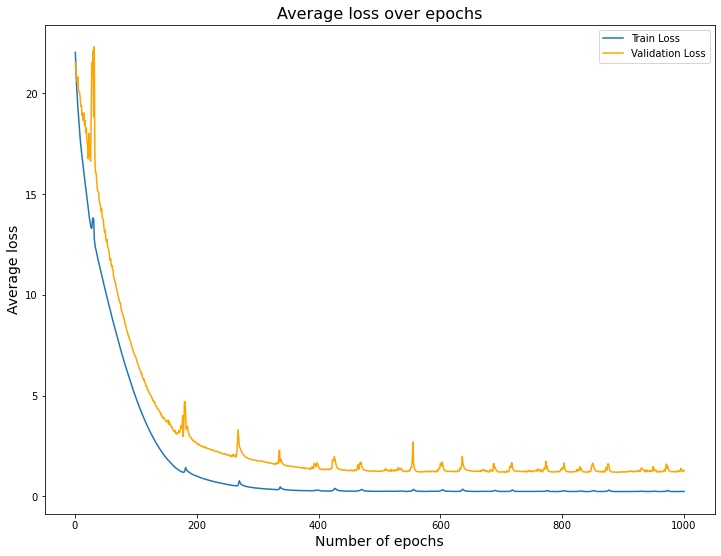

In [6]:
def plot_loss(train_losses, val_losses):
    """
    You may end up plotting the training loss and validation loss multiple times
    It is better to implement a plot function instead of rewriting the plotting steps
    """
    plt.figure(figsize = (12,9))
    plt.plot(range(1,len(train_losses)+1), train_losses)
    plt.plot(range(1,len(val_losses)+1), val_losses, color='orange')
    plt.legend(['Train Loss','Validation Loss'], loc='upper right')
    plt.xlabel('Number of epochs',fontsize=14)
    plt.ylabel('Average loss',fontsize=14)
    plt.title("Average loss over epochs",fontsize=16)
    plt.show()
plot_loss(train_losses, val_losses)


In [7]:

from sklearn.metrics import classification_report

print(classification_report(data_test['class'], val_preds))

              precision    recall  f1-score   support

           0       0.60      0.76      0.67        50
           1       0.78      0.70      0.74        50
           2       0.64      0.72      0.68        50
           3       0.76      0.52      0.62        50
           4       0.75      0.94      0.83        50
           5       0.64      0.50      0.56        50

    accuracy                           0.69       300
   macro avg       0.70      0.69      0.68       300
weighted avg       0.70      0.69      0.68       300



Confusion Matrix


[Text(0.5, 61.421875, 'Predicted label'), Text(61.421875, 0.5, 'True label')]

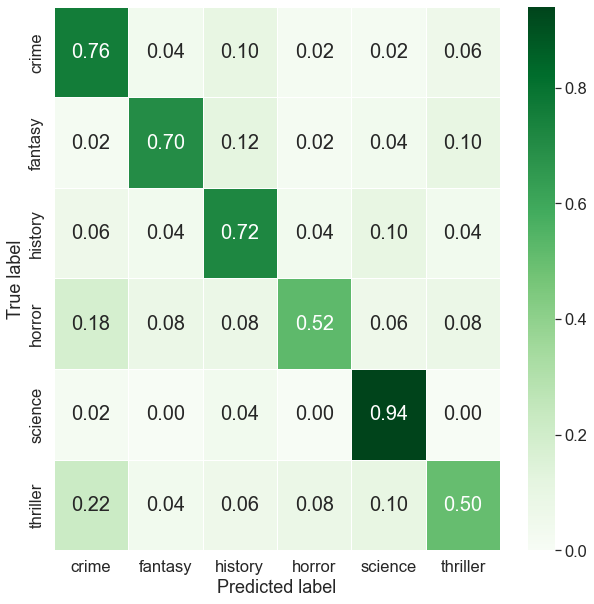

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cm = confusion_matrix(data_test['class'],val_preds)

#绘制confusion matrix
print("Confusion Matrix")
category_labels = ['crime', 'fantasy', 'history', 'horror', 'science', 'thriller']
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=1, square=False,
                cmap="Greens", yticklabels=category_labels, xticklabels=category_labels, vmin=0, vmax=np.max(cm_normalised),
                fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')